In [ ]:
import os
import tarfile
import requests
import tensorflow as tf
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [ ]:
if not os.path.exists('genres'):
    with open('genres_tar_file.tar.gz', 'wb') as file:
        response = requests.get('https://storage.googleapis.com/qwasar-public/track-ds/classically_punk_music_genres.tar.gz')
        file.write(response.content)

    with tarfile.open('genres_tar_file.tar.gz', 'r:gz') as tar:
        members = tar.getmembers()

        for member in members:
            if member.name.startswith(f'genres/'):
                tar.extract(member, path=os.getcwd())


In [ ]:
class AudioFeatureExtractor:
    def __init__(self, audios_path):
        self.__exts = []
        self.__ap = audios_path
        self.frame_size = 2048
        self.hop_length = 126
        self.num_frames = 10

    def as_dataframe(self):
        return pd.DataFrame(self.__exts)

    def save_csv(self, filename):
        df = self.as_dataframe()
        df.to_csv(filename, index=False)
        return df

    def process(self):
        for genre_or_file in os.listdir(self.__ap):
            path = os.path.join(self.__ap, genre_or_file)
            if not os.path.isdir(path):
                continue
            genre = str(genre_or_file).strip('/').strip('//')
            for audio in os.listdir(path):
                audio_path = os.path.join(path, audio)

                signal, sr = librosa.load(audio_path)
                frames = [signal[i:i + self.frame_size] for i in range(0, min(len(signal) - self.frame_size + 1, self.num_frames * self.hop_length), self.hop_length)]

                for frame in frames:
                    mfcc_features = librosa.feature.mfcc(y=frame, sr=sr)
                    chroma_features = librosa.feature.chroma_stft(y=frame, sr=sr)
                    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=frame)
                    spectral_centroid = librosa.feature.spectral_centroid(y=frame, sr=sr)
                    spectral_rolloff = librosa.feature.spectral_rolloff(y=frame, sr=sr)
                    chroma_energy = librosa.feature.chroma_cens(y=frame, sr=sr)

                    feature_dict = {
                        "chroma_energy": round(chroma_energy.mean(), 3),
                        "mfcc": round(mfcc_features.mean(), 3),
                        "chroma_stft": round(chroma_features.mean(), 3),
                        "zero_crossing_rate": round(zero_crossing_rate.mean(), 3),
                        "spectral_centroid": round(spectral_centroid.mean(), 3),
                        "spectral_rolloff": round(spectral_rolloff.mean(), 3),
                        "genre": genre,
                    }

                    print("Feature extracted", feature_dict)
                    self.__exts.append(feature_dict)


In [ ]:
extractor = AudioFeatureExtractor('genres')
extractor.process()

Streaming output truncated to the last 5000 lines.
Feature extracted {'chroma_energy': 0.257, 'mfcc': 9.5, 'chroma_stft': 0.631, 'zero_crossing_rate': 0.025, 'spectral_centroid': 3162.905, 'spectral_rolloff': 7831.626, 'genre': 'pop'}
Feature extracted {'chroma_energy': 0.252, 'mfcc': 8.693, 'chroma_stft': 0.621, 'zero_crossing_rate': 0.022, 'spectral_centroid': 2976.894, 'spectral_rolloff': 7556.001, 'genre': 'pop'}
Feature extracted {'chroma_energy': 0.254, 'mfcc': 8.355, 'chroma_stft': 0.709, 'zero_crossing_rate': 0.019, 'spectral_centroid': 2882.989, 'spectral_rolloff': 7413.882, 'genre': 'pop'}
Feature extracted {'chroma_energy': 0.263, 'mfcc': 8.075, 'chroma_stft': 0.683, 'zero_crossing_rate': 0.018, 'spectral_centroid': 2666.87, 'spectral_rolloff': 6959.531, 'genre': 'pop'}
Feature extracted {'chroma_energy': 0.27, 'mfcc': 7.748, 'chroma_stft': 0.701, 'zero_crossing_rate': 0.014, 'spectral_centroid': 2403.62, 'spectral_rolloff': 6429.814, 'genre': 'pop'}
Feature extracted {'chro

In [ ]:
df = extractor.save_csv('genres.csv')
print(df.shape)
df


(10000, 7)


,chroma_energy,mfcc,chroma_stft,zero_crossing_rate,spectral_centroid,spectral_rolloff,genre
0,0.264,0.614,0.359,0.111,2710.667,5058.149,jazz
1,0.265,1.311,0.374,0.111,2782.813,5221.802,jazz
2,0.267,0.953,0.377,0.112,2776.394,5271.328,jazz
3,0.273,1.081,0.402,0.108,2756.201,5254.102,jazz
4,0.277,1.386,0.385,0.105,2738.616,5389.761,jazz
...,...,...,...,...,...,...,...
9995,0.253,1.487,0.433,0.099,2885.525,6591.313,rock
9996,0.250,1.350,0.408,0.099,2883.002,6571.934,rock
9997,0.247,0.450,0.414,0.100,2922.688,6670.986,rock
9998,0.241,1.074,0.410,0.099,2936.936,6731.279,rock


In [ ]:
from itertools import islice

def plot_waveforms(input_path, num_rows=2, num_cols=5, output_filename='waveforms_for_audio_files.png'):

    subfolders = next(os.walk(input_path))[1]

    if len(subfolders) == 0:
        print("No subfolders found in the specified path.")
        return

    num_rows = min(len(subfolders), num_rows)
    num_cols = min(num_cols, len(subfolders) // num_rows) if num_rows > 0 else num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for i, folder in enumerate(subfolders):
        if i >= num_rows * num_cols:
            break
        folder_path = os.path.join(input_path, folder)

        for file in islice(os.listdir(folder_path), num_cols):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                row = i // num_cols
                col = i % num_cols
                axs[row, col].plot(audio, linewidth=1)
                axs[row, col].set_title(folder)
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])

    plt.tight_layout()
    fig.suptitle("Wafe plots")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()


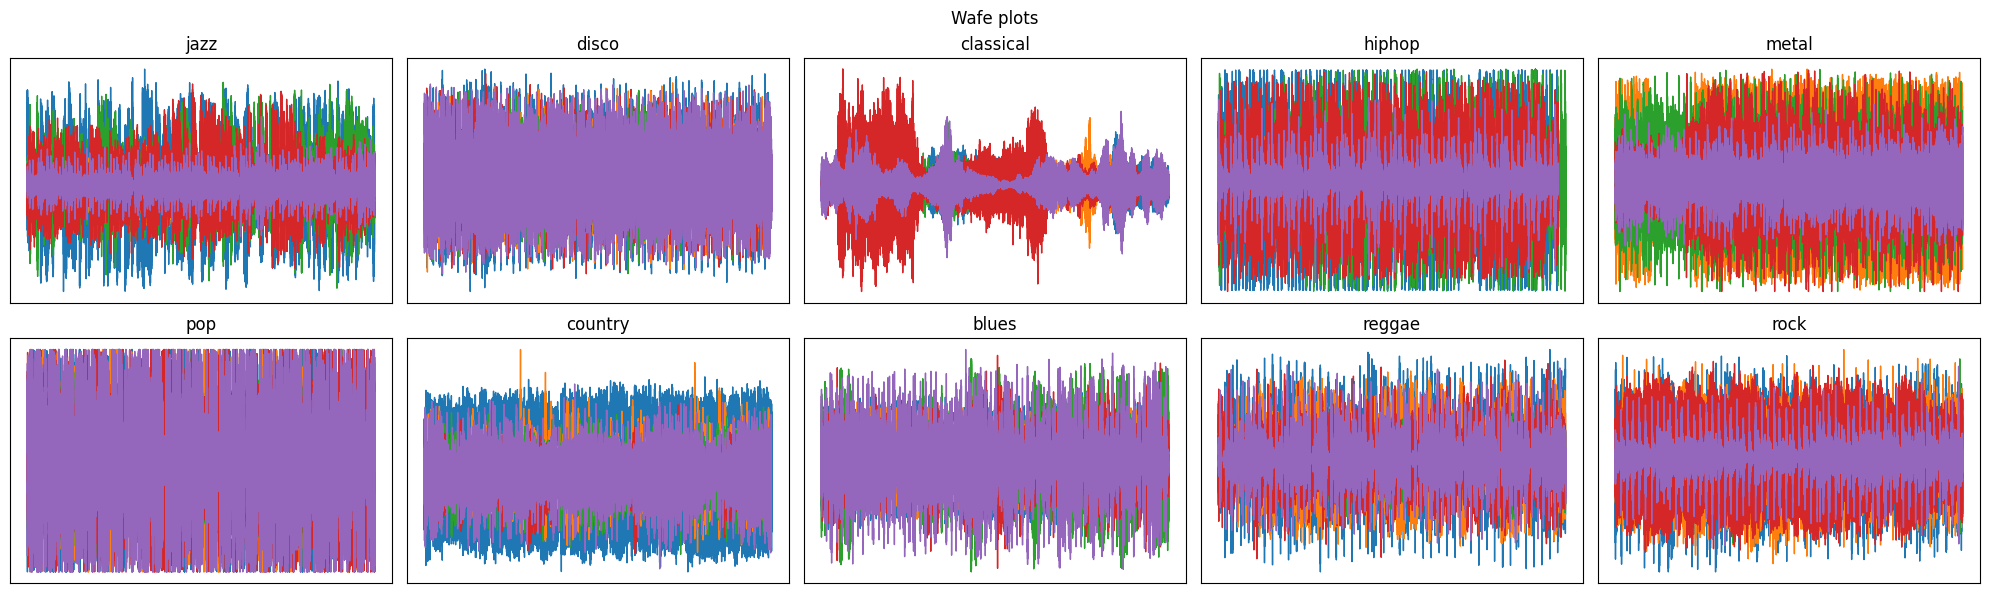

In [ ]:
plot_waveforms('genres')

In [ ]:
import librosa.display

def plot_mfcc_spectrograms(input_path, num_rows=2, num_cols=5, output_filename='mfcc_spectrograms.png'):

    subfolders = next(os.walk(input_path))[1]

    if len(subfolders) == 0:
        print("No subfolders found in the specified path.")
        return

    num_rows = min(len(subfolders), num_rows)
    num_cols = min(num_cols, len(subfolders) // num_rows) if num_rows > 0 else num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for i, folder in enumerate(subfolders):
        if i >= num_rows * num_cols:
            break
        folder_path = os.path.join(input_path, folder)

        for file in islice(os.listdir(folder_path), num_cols):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                stft = librosa.stft(audio)
                mfccs = librosa.feature.mfcc(S=stft, sr=sr)
                row = i // num_cols
                col = i % num_cols
                librosa.display.specshow(mfccs, x_axis='time', ax=axs[row, col])
                axs[row, col].set_title(folder)

    plt.tight_layout()
    fig.suptitle("MFCC Spectrograms")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()

def plot_chroma_stft_spectrograms(input_path, num_rows=2, num_cols=5, output_filename='chroma_stft_spectrograms.png'):

    subfolders = next(os.walk(input_path))[1]

    if len(subfolders) == 0:
        print("No subfolders found in the specified path.")
        return

    num_rows = min(len(subfolders), num_rows)
    num_cols = min(num_cols, len(subfolders) // num_rows) if num_rows > 0 else num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for i, folder in enumerate(subfolders):
        if i >= num_rows * num_cols:
            break
        folder_path = os.path.join(input_path, folder)

        for file in islice(os.listdir(folder_path), num_cols):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
                row = i // num_cols
                col = i % num_cols
                librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time', ax=axs[row, col])
                axs[row, col].set_title(folder)

    plt.tight_layout()
    fig.suptitle("Chroma STFT Spectrograms")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()

def plot_zero_crossing_rate_in_audio_files(input_path, num_rows=2, num_cols=5, output_filename='zero_crossing_rate_plots.png'):

    subfolders = next(os.walk(input_path))[1]

    if len(subfolders) == 0:
        print("No subfolders found in the specified path.")
        return

    num_rows = min(len(subfolders), num_rows)
    num_cols = min(num_cols, len(subfolders) // num_rows) if num_rows > 0 else num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for i, folder in enumerate(subfolders):
        if i >= num_rows * num_cols:
            break
        folder_path = os.path.join(input_path, folder)

        for file in islice(os.listdir(folder_path), num_cols):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                zero_crossings = librosa.feature.zero_crossing_rate(audio)
                row = i // num_cols
                col = i % num_cols
                time = librosa.times_like(zero_crossings)
                axs[row, col].plot(time, zero_crossings[0], label='Zero Crossing Rate')
                axs[row, col].set_title(folder)
                axs[row, col].legend()

    plt.tight_layout()
    fig.suptitle("Zero Crossing Rate Plots")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()

def count_zero_crossings_in_audio_files(input_path):
    subfolders = next(os.walk(input_path))[1]

    if len(subfolders) == 0:
        print("No subfolders found in the specified path.")
        return

    for folder in subfolders:
        folder_path = os.path.join(input_path, folder)
        total_zero_crossings = 0

        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                total_zero_crossings += sum(librosa.feature.zero_crossings(audio))

        print(f'Total zero crossings in {folder}: {total_zero_crossings}')


def plot_spectral_centroid_in_audio_files(input_path, num_rows=2, num_cols=5, output_filename='spectral_centroid_plots.png'):

    subfolders = next(os.walk(input_path))[1]

    if len(subfolders) == 0:
        print("No subfolders found in the specified path.")
        return

    num_rows = min(len(subfolders), num_rows)
    num_cols = min(num_cols, len(subfolders) // num_rows) if num_rows > 0 else num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for i, folder in enumerate(subfolders):
        if i >= num_rows * num_cols:
            break
        folder_path = os.path.join(input_path, folder)

        spectral_centroids = []

        for file in islice(os.listdir(folder_path), num_cols):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                spectral_centroids.append(librosa.feature.spectral_centroid(y=audio, sr=sr)[0])

        row = i // num_cols
        col = i % num_cols
        time = np.arange(0, len(spectral_centroids[0])) * (len(audio) / len(spectral_centroids[0]))
        axs[row, col].plot(time, spectral_centroids[0], label='Spectral Centroid')
        axs[row, col].set_title(folder)
        axs[row, col].legend()

    plt.tight_layout()
    fig.suptitle("Spectral Centroid Plots")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()

def plot_spectral_rolloff_in_audio_files(input_path, num_rows=2, num_cols=5, output_filename='spectral_rolloff_plots.png'):

    subfolders = next(os.walk(input_path))[1]

    if len(subfolders) == 0:
        print("No subfolders found in the specified path.")
        return

    num_rows = min(len(subfolders), num_rows)
    num_cols = min(num_cols, len(subfolders) // num_rows) if num_rows > 0 else num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for i, folder in enumerate(subfolders):
        if i >= num_rows * num_cols:
            break
        folder_path = os.path.join(input_path, folder)

        spectral_rolloffs = []

        for file in islice(os.listdir(folder_path), num_cols):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                spectral_rolloffs.append(librosa.feature.spectral_rolloff(y=audio, sr=sr)[0])

        row = i // num_cols
        col = i % num_cols
        time = np.arange(0, len(spectral_rolloffs[0])) * (len(audio) / len(spectral_rolloffs[0]))
        axs[row, col].plot(time, spectral_rolloffs[0], label='Spectral Rolloff')
        axs[row, col].set_title(folder)
        axs[row, col].legend()

    plt.tight_layout()
    fig.suptitle("Spectral Rolloff Plots")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()


<ipython-input-46-4c114ed84b69>:29: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(mfccs, x_axis='time', ax=axs[row, col])


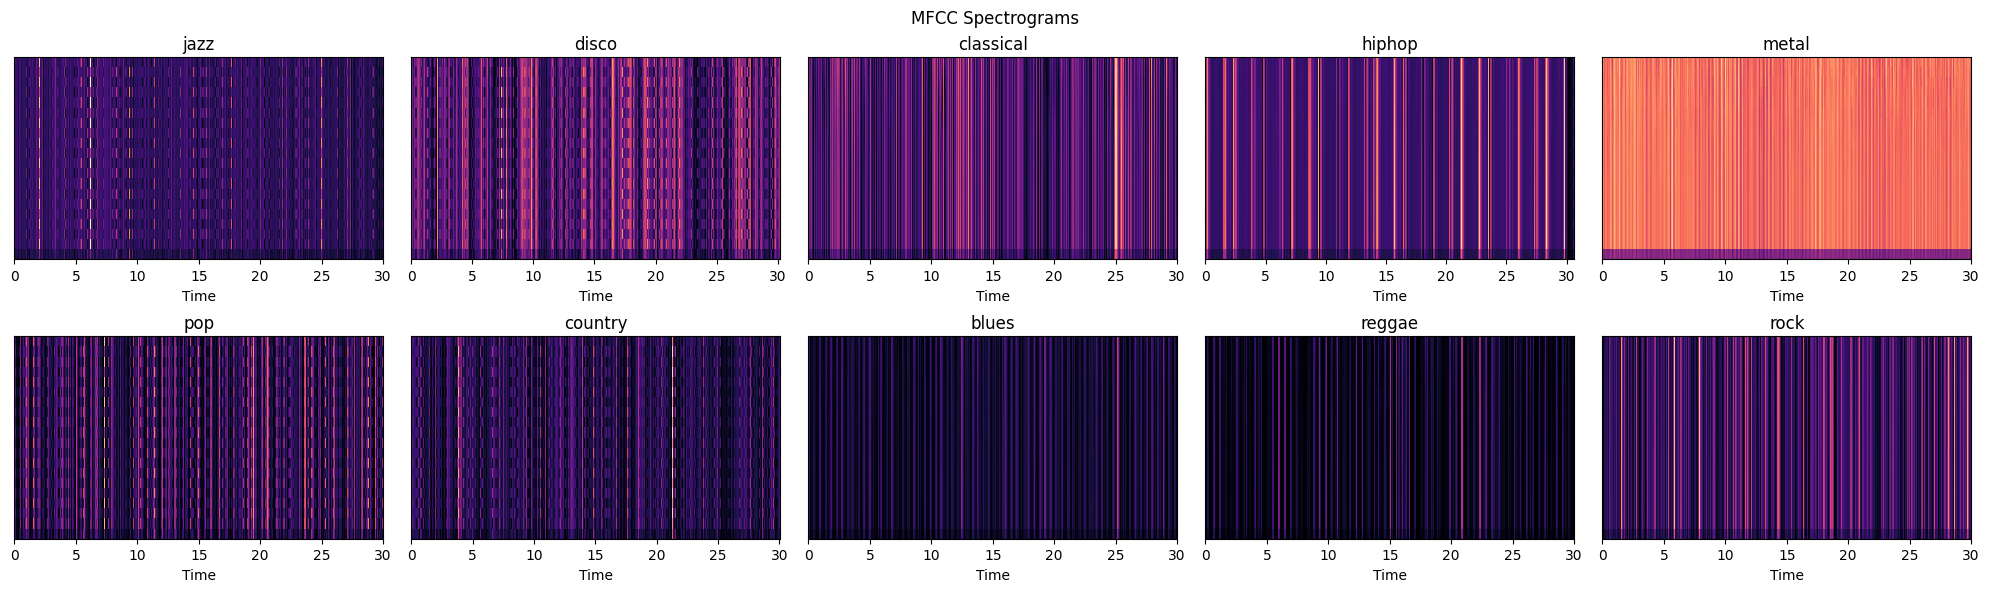

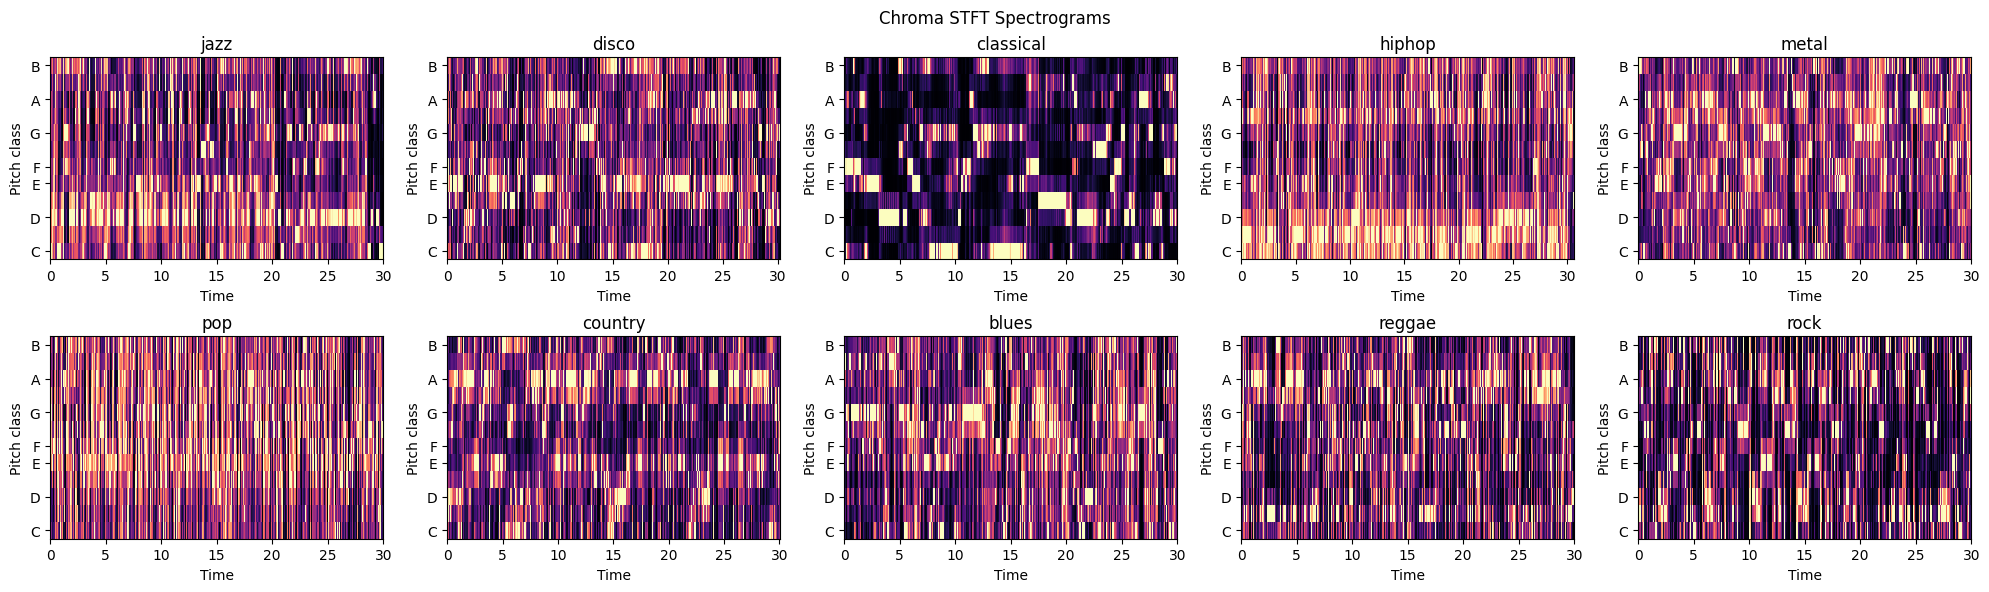

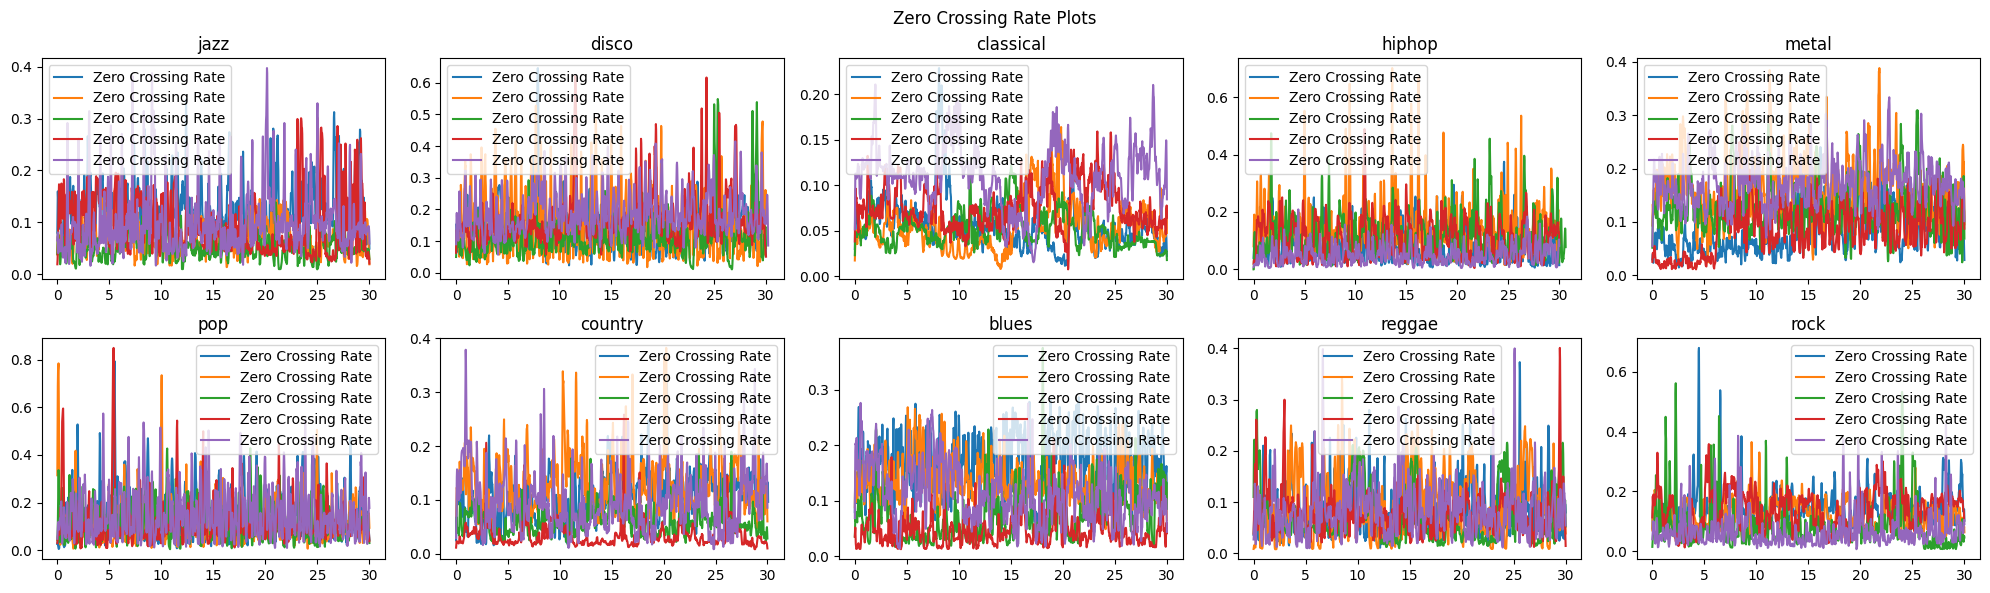

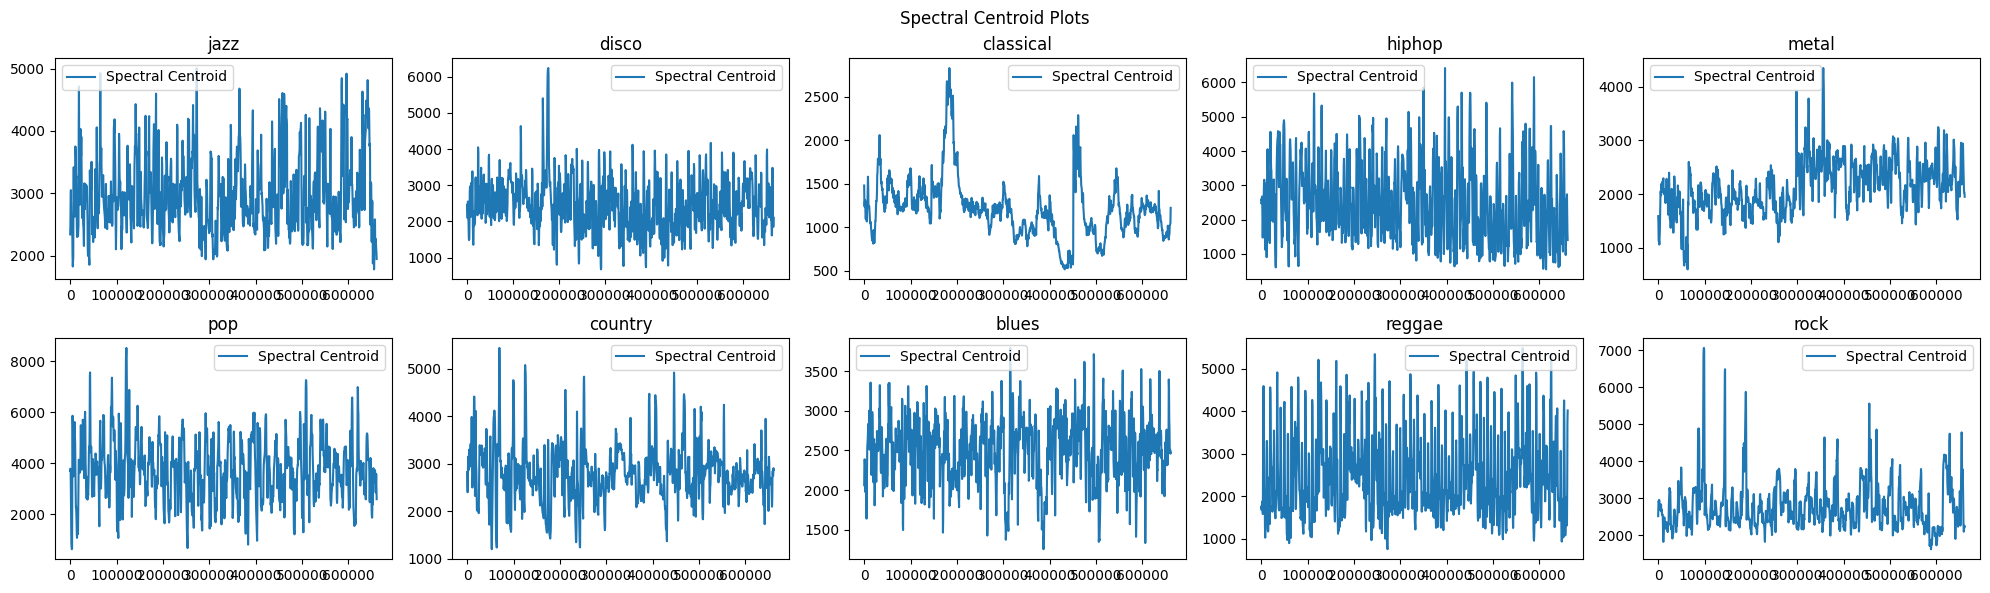

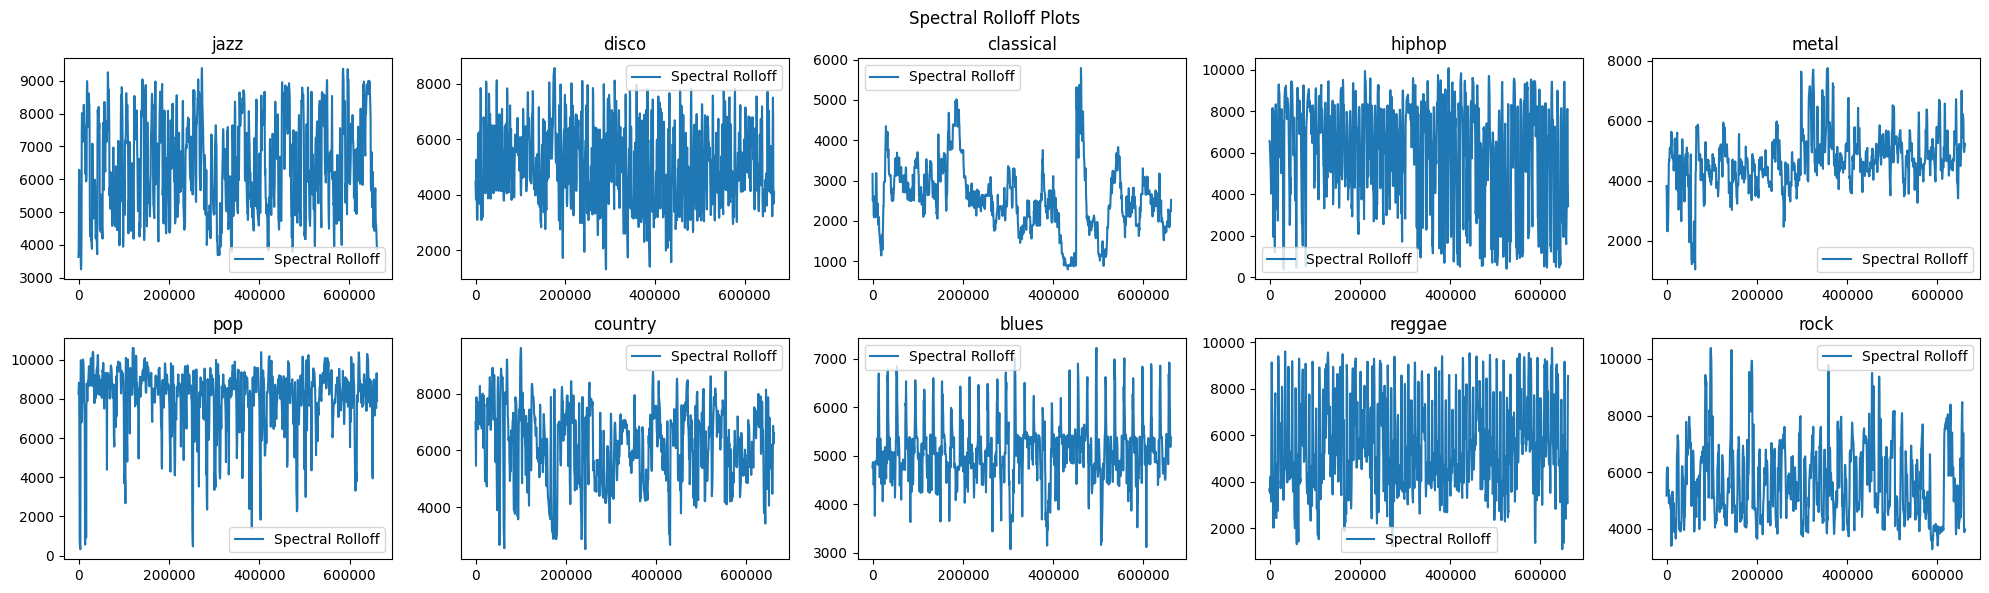

In [ ]:
plot_mfcc_spectrograms("genres")
plot_chroma_stft_spectrograms("genres")
plot_zero_crossing_rate_in_audio_files("genres")
plot_spectral_centroid_in_audio_files("genres")
plot_spectral_rolloff_in_audio_files("genres")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

In [ ]:
X = np.array(df.iloc[:, :-1], dtype='float32')
shape = X.shape

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

def scale_features(X):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(X)
    return scaled_features

X_train_scaled = scale_features(X_train)
X_validation_scaled = scale_features(X_validation)
X_test_scaled = scale_features(X_test)

num_classes = len(np.unique(y_encoded))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_validation_encoded = to_categorical(y_validation, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)


In [ ]:
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 128)               896       
                                                                 
 dense_78 (Dense)            (None, 32)                4128      
                                                                 
 batch_normalization_42 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dense_79 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_43 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dense_80 (Dense)            (None, 32)              

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


history = model.fit(X_train_scaled, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_validation_scaled, y_validation_encoded))

results = model.evaluate(X_test_scaled, y_test_encoded)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])



Epoch 1/100
250/250 [==============================] - 3s 4ms/step - loss: 1.9983 - accuracy: 0.3001 - val_loss: 1.9958 - val_accuracy: 0.3030
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 1.7654 - accuracy: 0.3691 - val_loss: 1.6927 - val_accuracy: 0.3820
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 1.6812 - accuracy: 0.4008 - val_loss: 1.6453 - val_accuracy: 0.3990
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 1.6227 - accuracy: 0.4313 - val_loss: 1.6129 - val_accuracy: 0.4030
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 1.5902 - accuracy: 0.4324 - val_loss: 1.5599 - val_accuracy: 0.4210
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 1.5333 - accuracy: 0.4559 - val_loss: 1.5344 - val_accuracy: 0.4280
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 1.5041 - accuracy: 0.4666 - val_loss: 1.5135 - val_accuracy: 0.4600

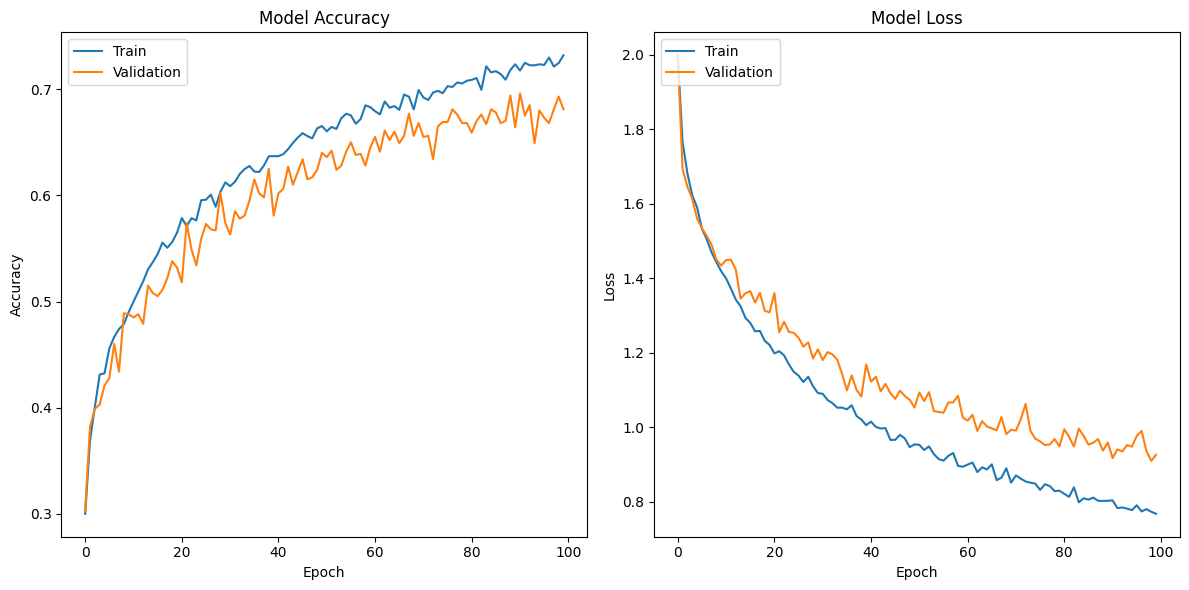

In [ ]:
plot_training_history(history)